# Final Project: NYC Inmates in Custody

Shelsea Henry and Jacqueline Noborikawa


https://data.cityofnewyork.us/api/odata/v4/7479-ugqb

https://data.cityofnewyork.us/Public-Safety/Daily-Inmates-In-Custody/7479-ugqb

In [440]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import re

# Import Data

In [441]:
file = 'Daily_Inmates_In_Custody_Final.csv'
data = pd.read_csv(file)

# Clean Data

In [442]:
data.dtypes

INMATEID                int64
ADMITTED_DT            object
DISCHARGED_DT         float64
CUSTODY_LEVEL          object
BRADH                  object
RACE                   object
GENDER                 object
AGE                   float64
INMATE_STATUS_CODE     object
SEALED                 object
SRG_FLG                object
TOP_CHARGE             object
INFRACTION             object
dtype: object

Dropping irrelevant columns that are blank or not necessary for our presentation. Renaming columns for an easier understanding of our data.

In [443]:
data.drop(['DISCHARGED_DT', 'INMATE_STATUS_CODE', 'SEALED', 'TOP_CHARGE'], axis=1, inplace=True)
data = data.rename(index=str, columns={'BRADH':'MENTAL_OBSERVATION', 'SRG_FLG':'GANG_AFFILIATION'})

Drop all the rows that have less than 8 filled columns

In [444]:
data.dropna(thresh=8, inplace = True)

Checked to see which columns still had empty data

In [445]:
data.isnull().any()

INMATEID              False
ADMITTED_DT           False
CUSTODY_LEVEL          True
MENTAL_OBSERVATION    False
RACE                  False
GENDER                False
AGE                   False
GANG_AFFILIATION      False
INFRACTION            False
dtype: bool

Filled all those with empty data with 'MISSING' or 'U' (undefined)

In [446]:
data['CUSTODY_LEVEL'].fillna(value = 'MISSING', inplace = True)
data['RACE'].fillna(value = 'U', inplace = True)
data['GENDER'].fillna(value = 'U', inplace = True)

In [447]:
data.isnull().any()

INMATEID              False
ADMITTED_DT           False
CUSTODY_LEVEL         False
MENTAL_OBSERVATION    False
RACE                  False
GENDER                False
AGE                   False
GANG_AFFILIATION      False
INFRACTION            False
dtype: bool

# Recode Data

Split the 'ADMITTED_DT' (Admitted Date) column into 'ADMIT_MONTH' and 'ADMIT_YEAR' for easier use in our graphs and prediction

In [448]:
i = 0
for row in data['ADMITTED_DT']:
    s = row.split("/")
    month = s[0]
    s = s[2].split(" ")
    year = s[0]
    data.loc[data.index[i], 'ADMIT_MONTH'] = month
    data.loc[data.index[i], 'ADMIT_YEAR'] = year
    i += 1

Regroup the 'AGE' into 'AGE_RE' that groups the ages into 10s

In [449]:
i = 0
for i in range(0, data.shape[0]):
    if data['AGE'][i] <= 20:
        data.loc[data.index[i], 'AGE_RE'] = '-20'
    elif 21 <= data['AGE'][i] < 30:
        data.loc[data.index[i], 'AGE_RE'] = '20s'
    elif 30 <= data['AGE'][i] < 40:
        data.loc[data.index[i], 'AGE_RE'] = '30s'
    elif 40 <= data['AGE'][i] < 50:
        data.loc[data.index[i], 'AGE_RE'] = '40s'
    elif 50 <= data['AGE'][i] < 60:
        data.loc[data.index[i], 'AGE_RE'] = '50s'
    elif 60 <= data['AGE'][i] < 70:
        data.loc[data.index[i], 'AGE_RE'] = '60s'
    elif 70 <= data['AGE'][i] < 80:
        data.loc[data.index[i], 'AGE_RE'] = '70s'
    elif data['AGE'][i] >=80:
        data.loc[data.index[i], 'AGE_RE'] = '80+'
    i += 1

Recode 'RACE' to make 'I' into 'U' 

In [450]:
i = 0
for i in range(0, data.shape[0]):
    if data['RACE'][i] == 'B':
        data.loc[data.index[i], 'RACE_RE'] = 'B'
    elif data['RACE'][i] == 'O':
        data.loc[data.index[i], 'RACE_RE'] = 'O'
    elif data['RACE'][i] == 'W':
        data.loc[data.index[i], 'RACE_RE'] = 'W'
    elif data['RACE'][i] == 'A':
        data.loc[data.index[i], 'RACE_RE'] = 'A'
    elif data['RACE'][i] == 'U':
        data.loc[data.index[i], 'RACE_RE'] = 'U'
    elif data['RACE'][i] == 'I':
        data.loc[data.index[i], 'RACE_RE'] = 'U'
    i += 1

# Description

In [452]:
data.CUSTODY_LEVEL.value_counts()

MED        3434
MIN        2794
MAX        2261
MISSING     145
Name: CUSTODY_LEVEL, dtype: int64

In [453]:
data.RACE_RE.value_counts()

B    4782
O    2748
W     932
A     136
U      36
Name: RACE_RE, dtype: int64

# Graphs

In [454]:
%matplotlib inline
mpl.rcParams['figure.dpi']= 300

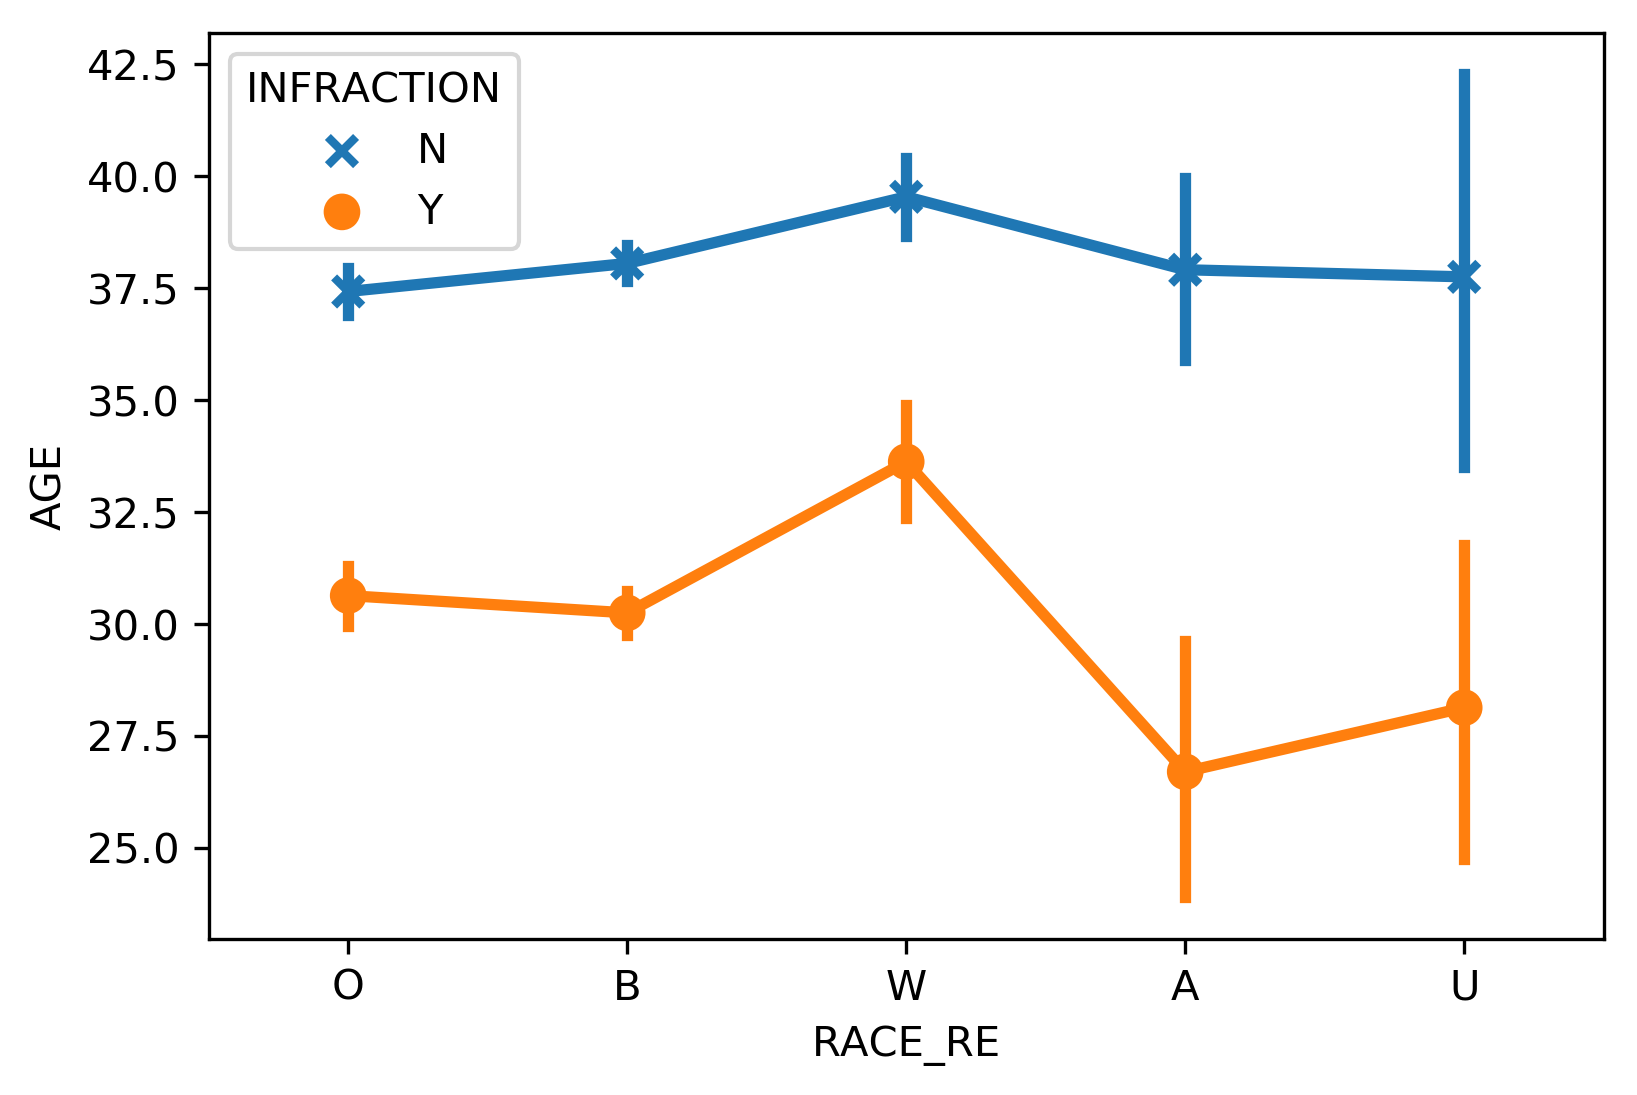

In [455]:
sns.pointplot(x="RACE_RE", y="AGE", hue="INFRACTION", data=data,
              markers=['x','o']);

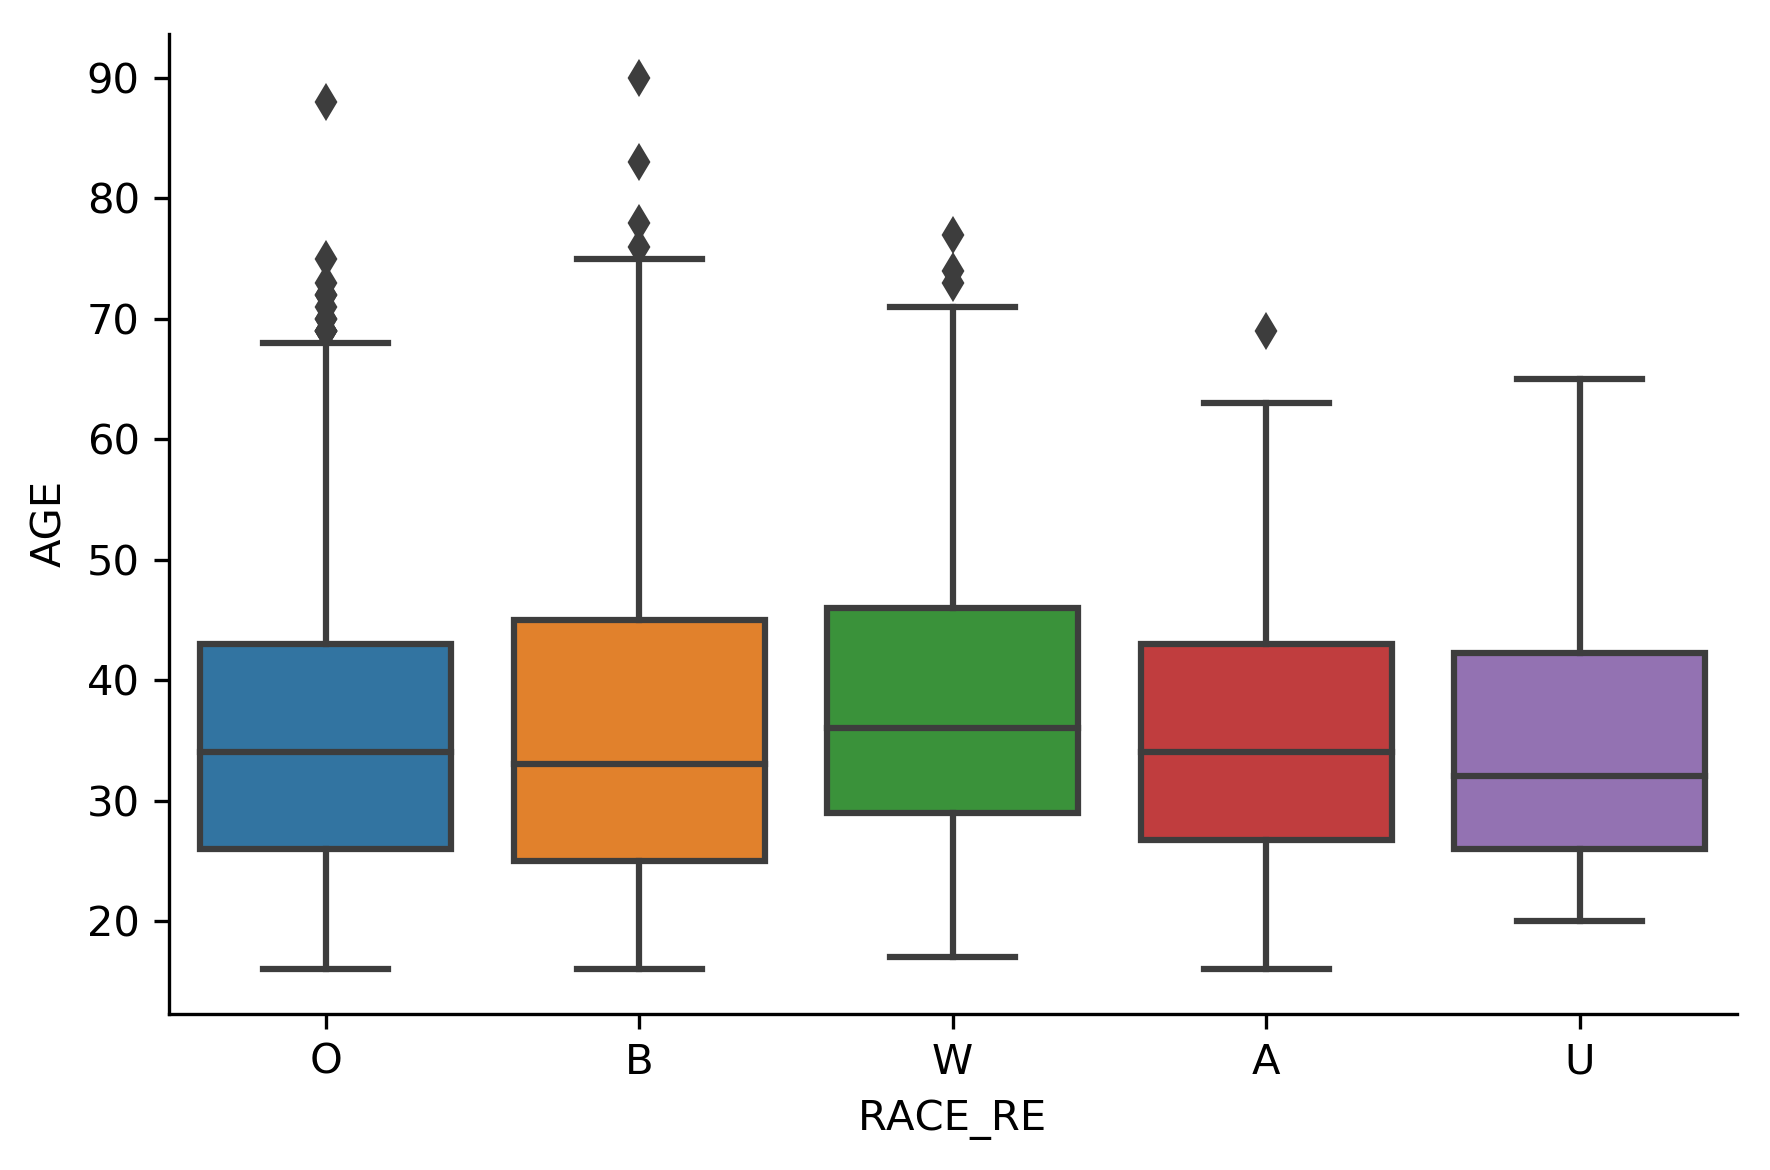

In [456]:
sns.boxplot(x='RACE_RE', y='AGE', data=data)
sns.despine()
plt.tight_layout()

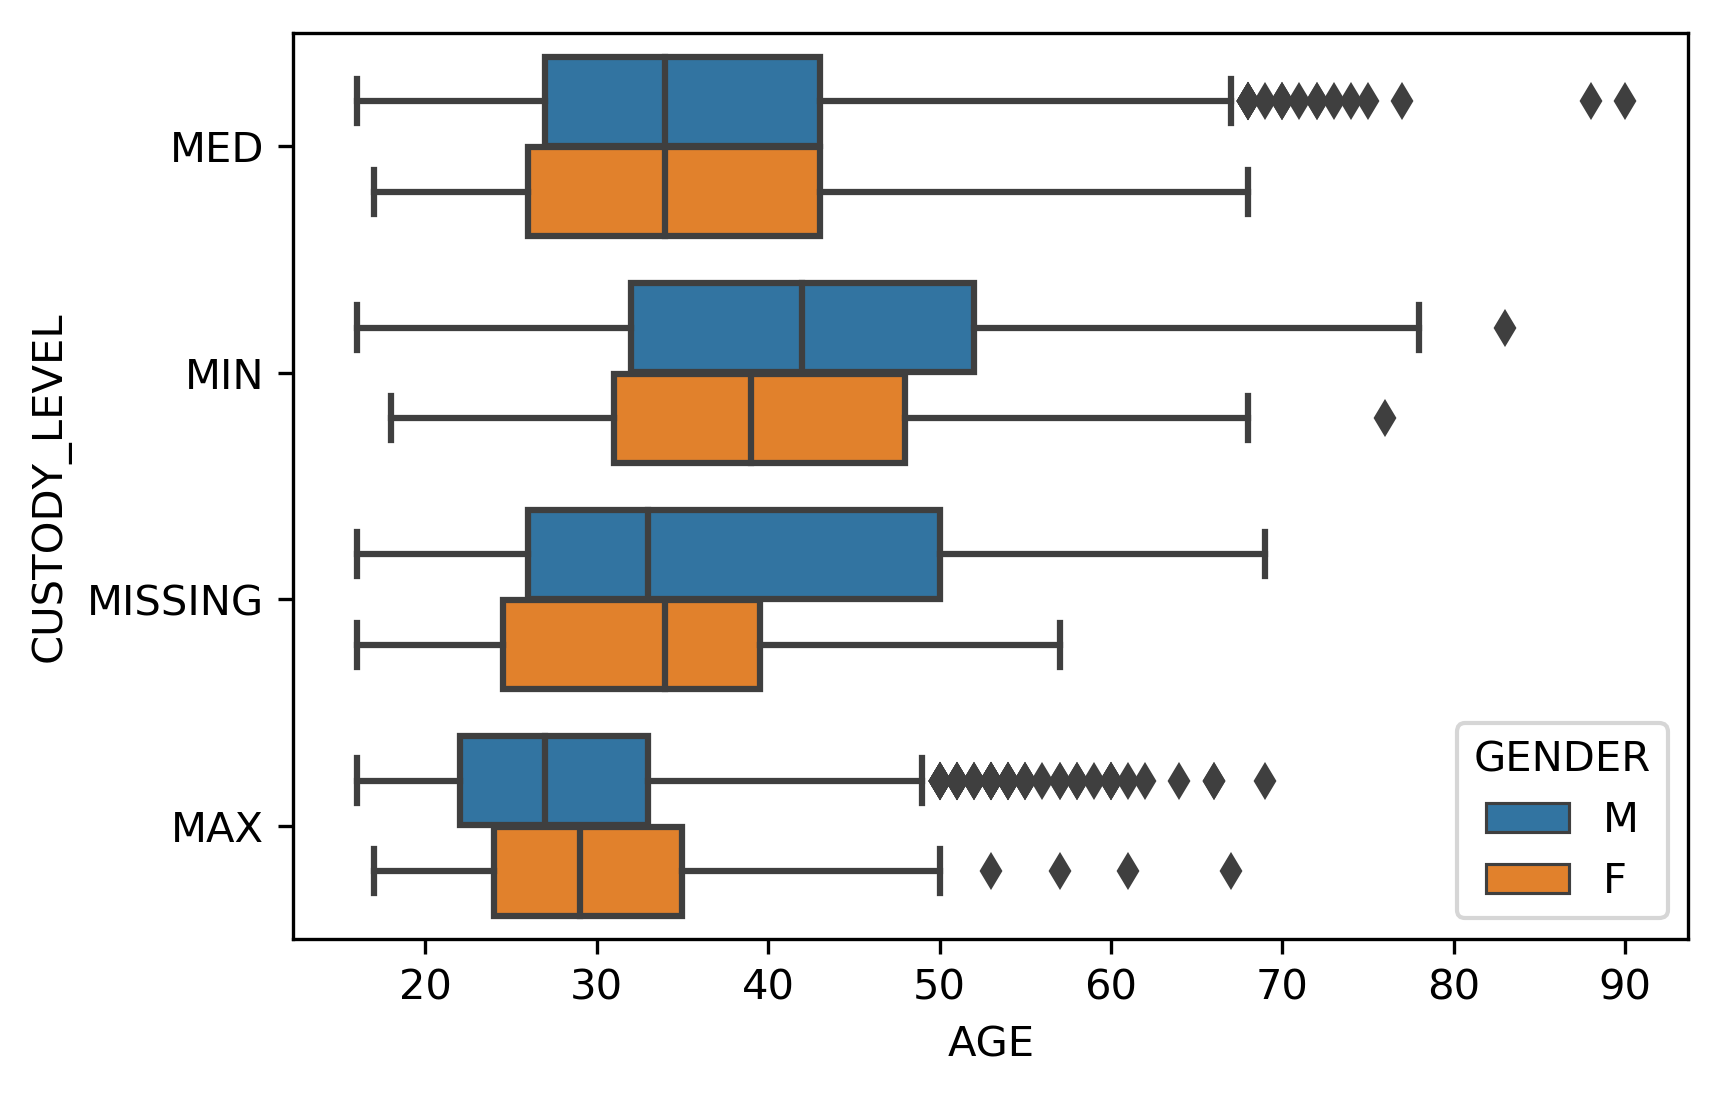

In [457]:
sns.boxplot(x="AGE", y="CUSTODY_LEVEL", hue="GENDER", data=data)

Text(0.5,1,'Age distribution')

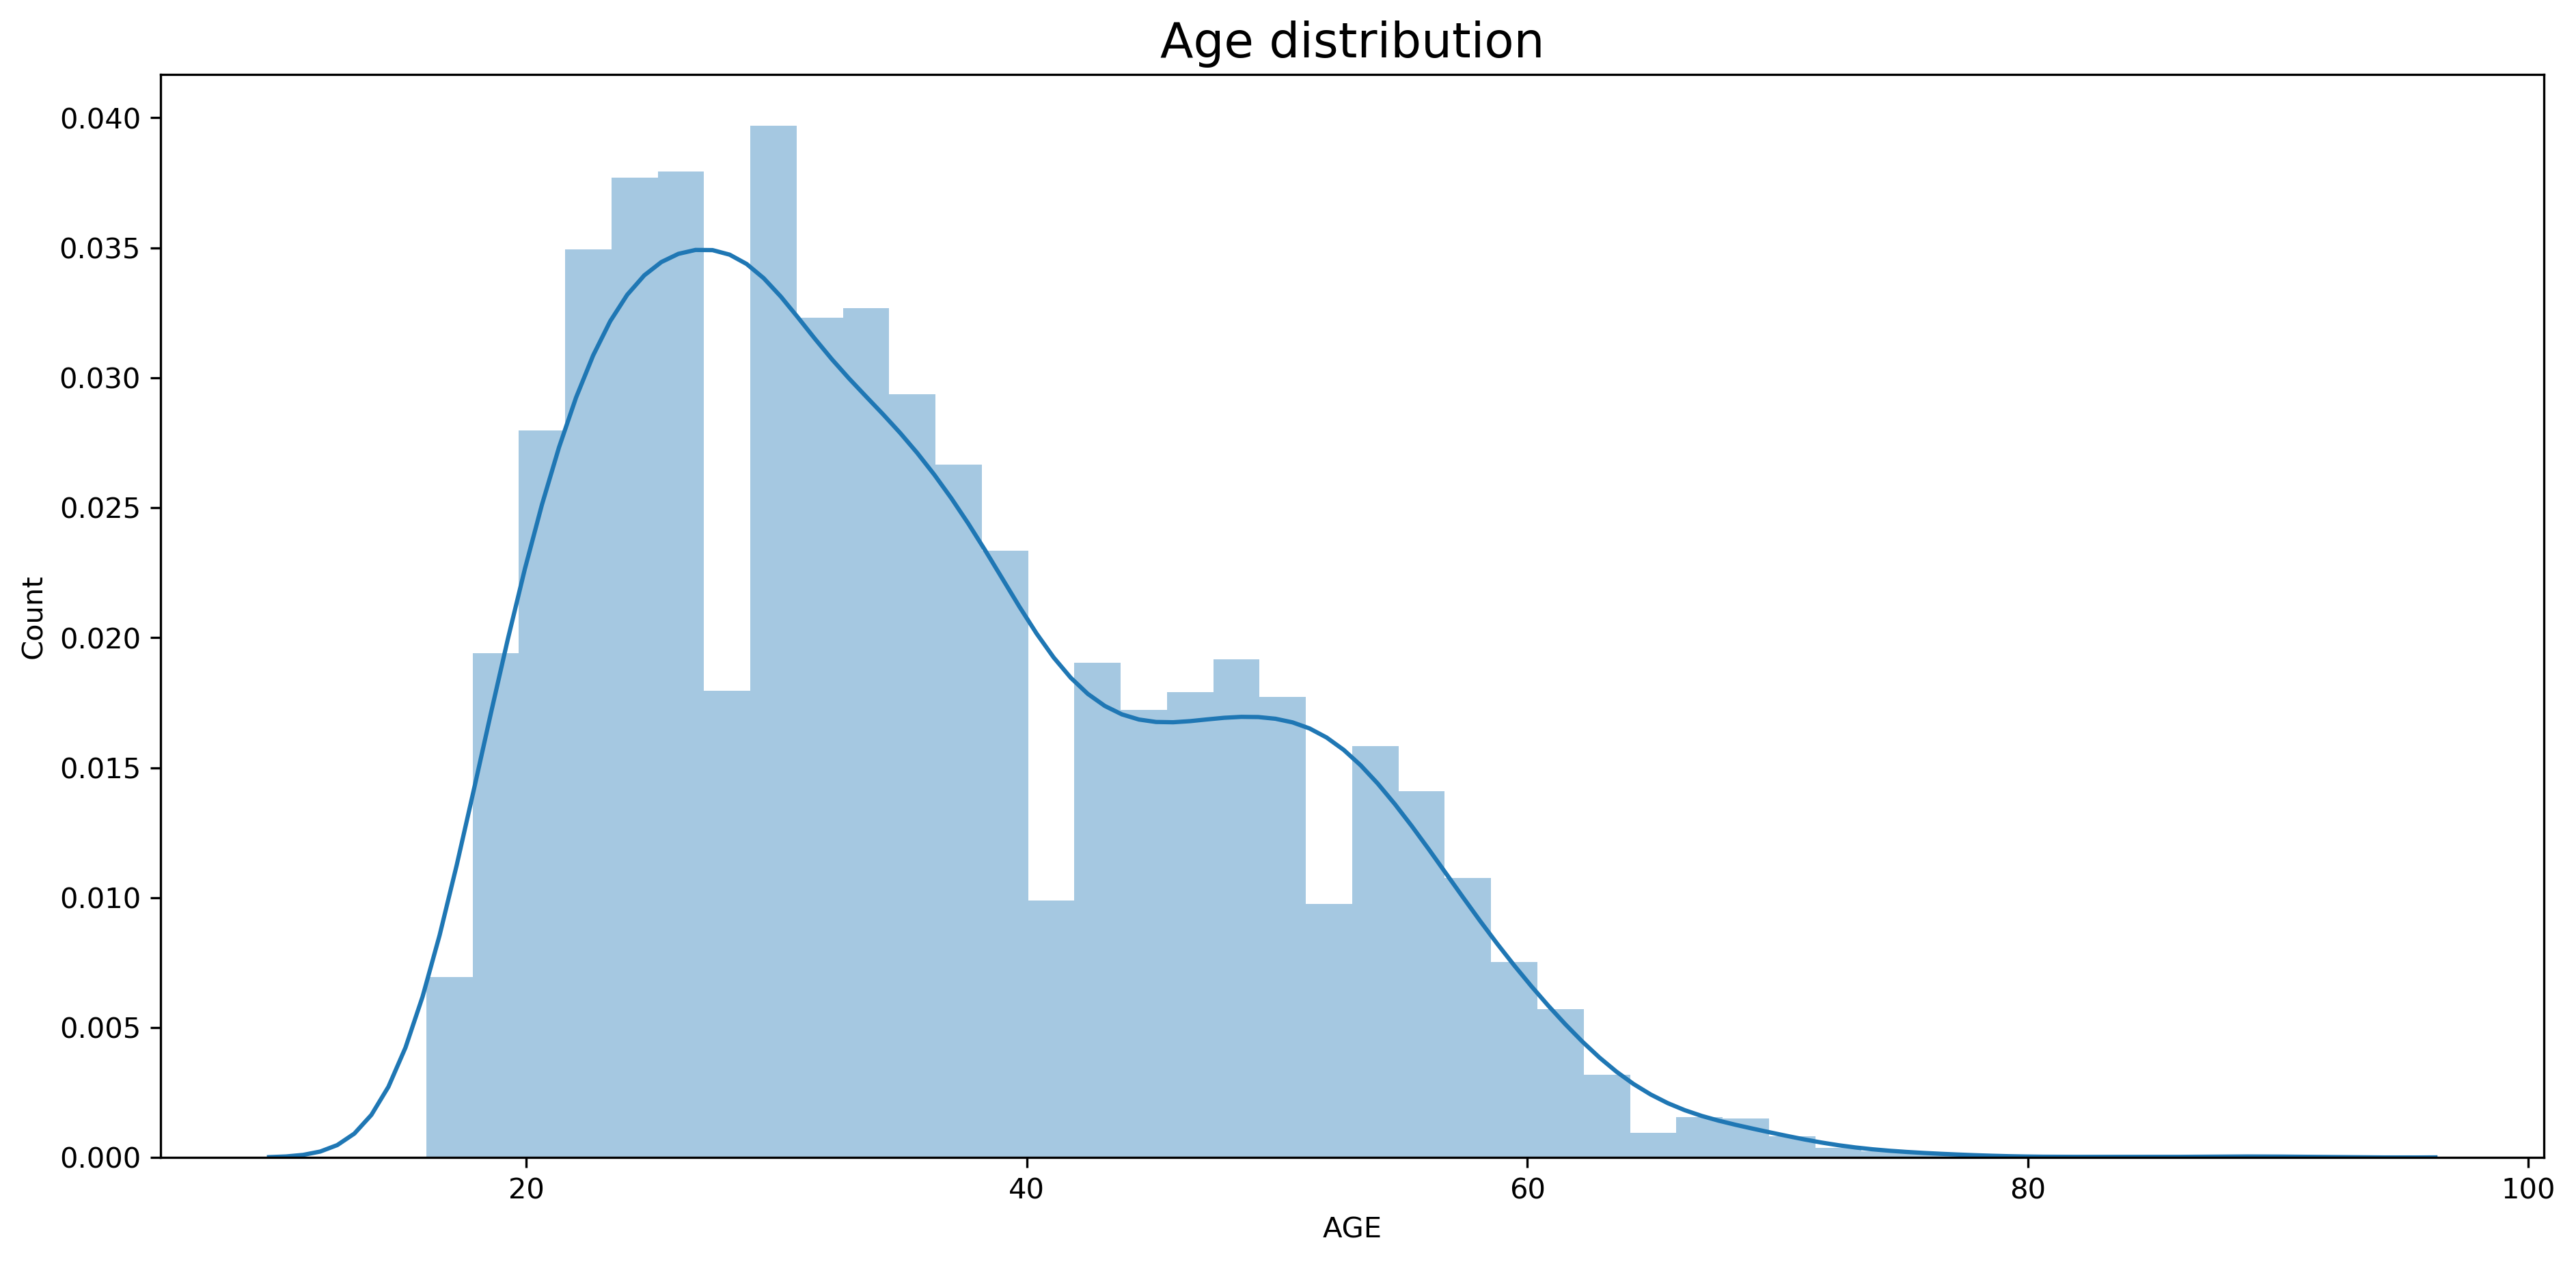

In [458]:
plt.figure(figsize=(15,7))
age_dist=sns.distplot(data["AGE"], bins=40)
age_dist.set(xlabel="AGE", ylabel="Count")

plt.title("Age distribution", fontsize=17)

# Predictions

Drop the 'ADMITTED_DT', 'AGE_RE' and 'RACE' columns

In [460]:
data.drop(['ADMITTED_DT', 'AGE_RE', 'RACE'], axis = 1, inplace = True)

Delete the rows where the custody level is 'MED' and 'MISSING'. This way, there are only 2 possible outcomes and we can use the prediction matrix 

In [461]:
data = data[data.CUSTODY_LEVEL != 'MED']
data = data[data.CUSTODY_LEVEL != 'MISSING']

Identify the ID, target, categorical, numerical, other columns in the data

In [462]:
ID_col = ['INMATEID']
target_col = ['CUSTODY_LEVEL']
cat_cols = ['MENTAL_OBSERVATION', 'RACE_RE', 'GENDER', 'GANG_AFFILIATION', 'INFRACTION', 'ADMIT_MONTH', 'ADMIT_YEAR']
num_cols = ['AGE']

Graph to be used to show the importance of the 'AGE' and 'INFRACTION' to determine the custody level

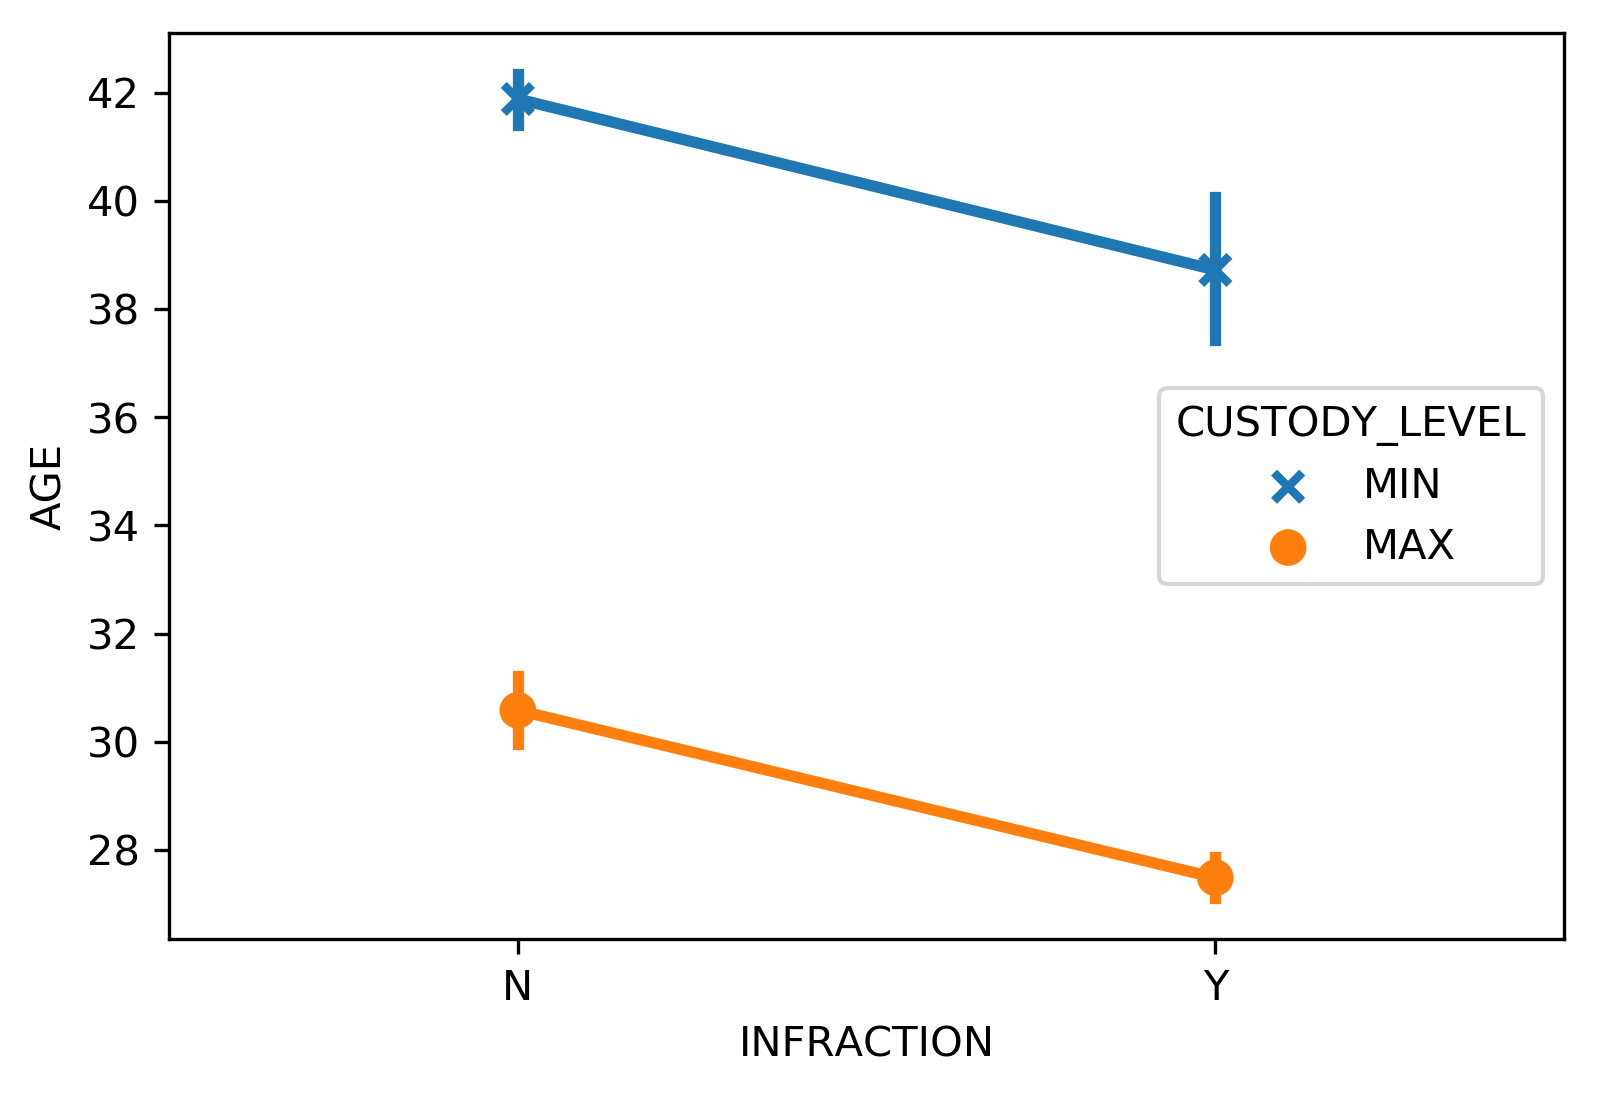

In [463]:
sns.pointplot(x="INFRACTION", y="AGE", hue="CUSTODY_LEVEL", data=data,
              markers=['x','o']);

For categorical and target variables, convert to numbers

In [464]:
for var in cat_cols:
    number = LabelEncoder()
    data[var] = number.fit_transform(data[var].astype('str'))
    
data['CUSTODY_LEVEL'] = number.fit_transform(data['CUSTODY_LEVEL'].astype('str'))

Split the data for training and validation

In [465]:
data['is_train'] = np.random.uniform(0, 1, len(data)) <= .50
train  = data[data['is_train'] == True]
validate = data[data['is_train'] == False]

Pass data into features variable

In [466]:
features = list(set(list(data.columns))-set(ID_col)-set(target_col))

Create the confusion matrix

In [467]:
x_train = train[list(features)].values
y_train = train['CUSTODY_LEVEL'].values
x_validate = validate[list(features)].values
y_validate = validate['CUSTODY_LEVEL'].values

In [468]:
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [469]:
status = rf.predict_proba(x_validate)

y_pred = status[:,1] > 0.5
y_true = y_validate

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 919  204]
 [ 242 1231]]


Calculate the accuracy of the prediction model

In [470]:
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.893865476469


Create the visualization of the performance

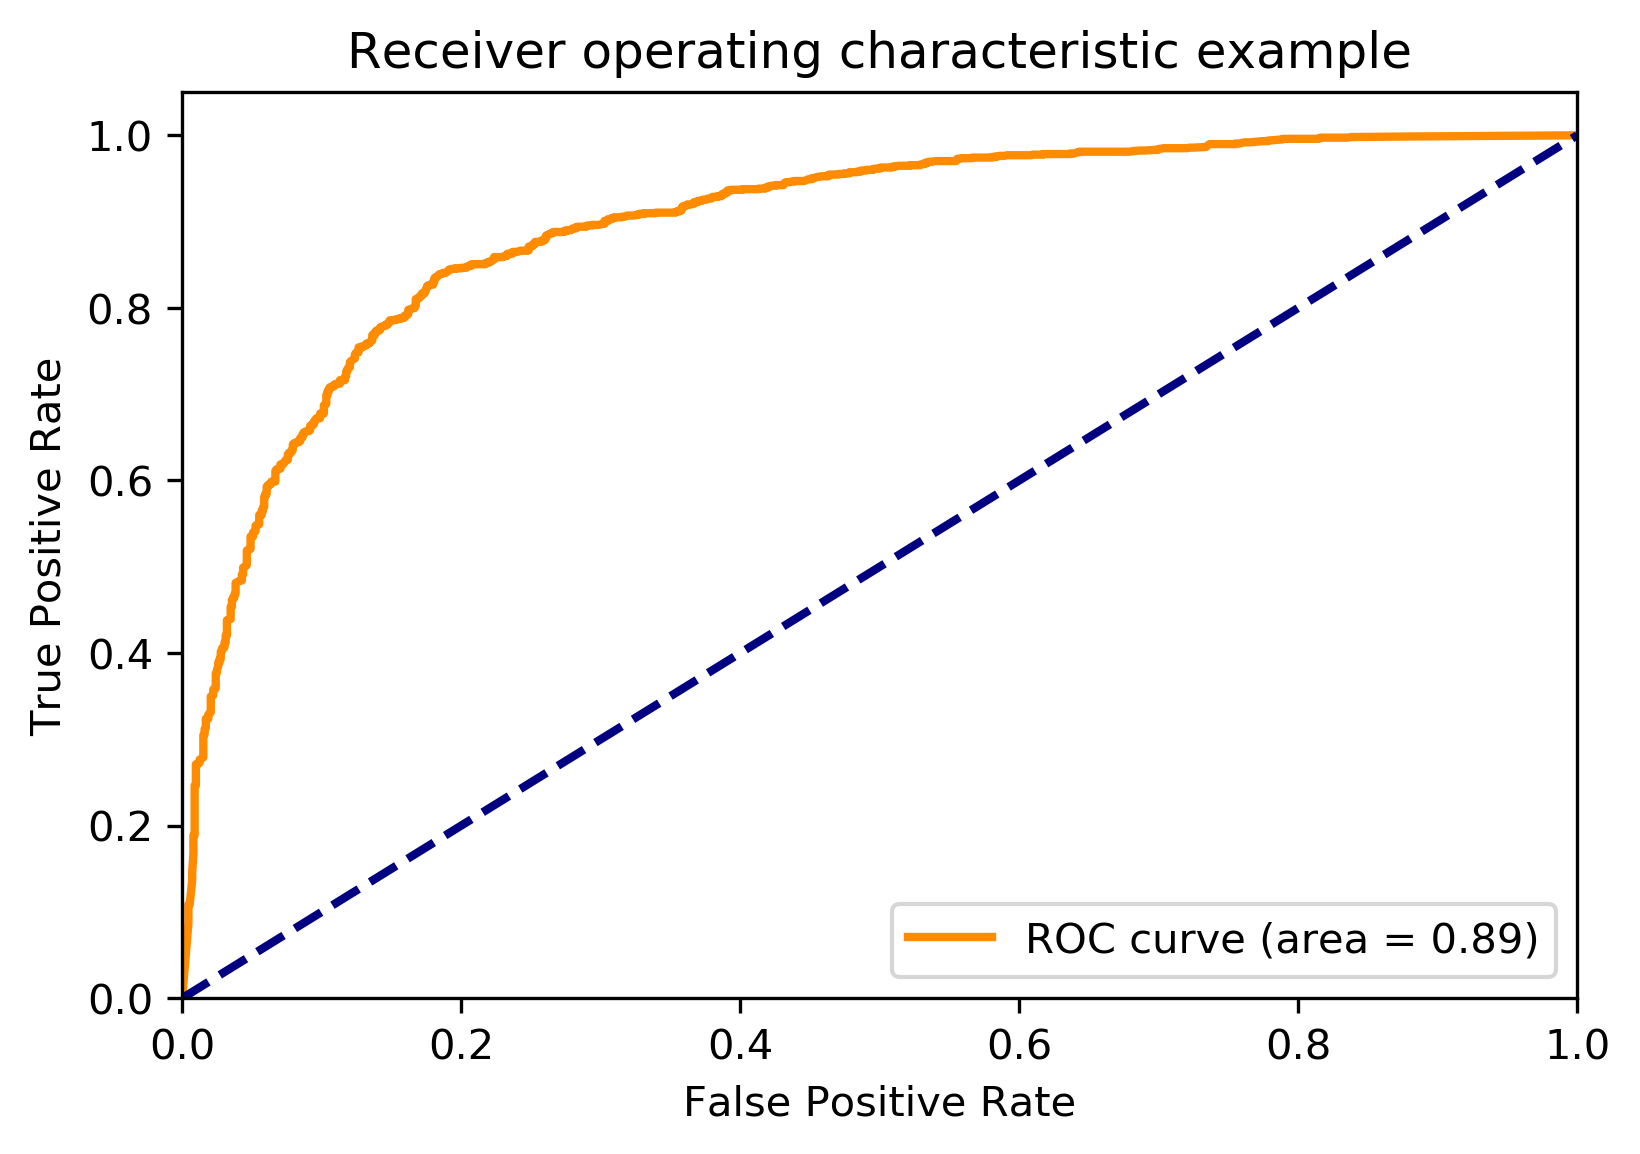

In [471]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()